In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error, \
r2_score, mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

from tqdm import tqdm_notebook

import warnings

warnings.filterwarnings("ignore")

RAND=10

**Задача**:
    
    - Требуется построить модель, предсказывающую стоимость дома (SalePrice)
    
    - Метрикой качества является средняя относительная ошибка предсказания (Root-Mean-Squared-Error (RMSE))
    
    - Целевая переменная - SalePrice. Стоимость дома по 79 имеющимся признакам.

# Импорт данных

In [3]:
train = pd.read_csv('../Kaggle/train.csv')
test = pd.read_csv('../Kaggle/test.csv')

In [4]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Проверим данные на выбросы

In [7]:
# отобразим все столбцы в таблице

pd.set_option('display.max_columns', None)

In [8]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


По максимальным - минимальным значениям смотрим на данные и проверяем их на корректность 

In [11]:
train.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


Никаких выбросов / нетипичных данных нет

# Data Exploration

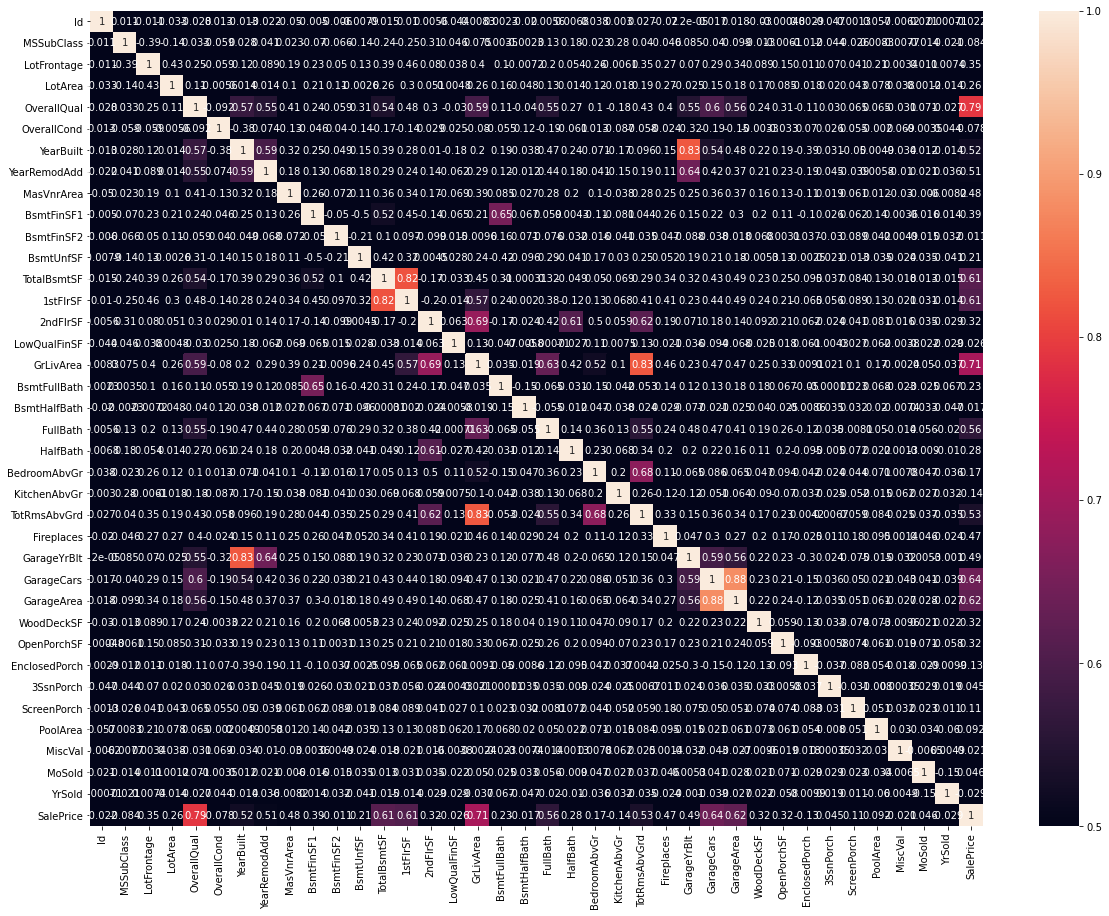

In [6]:
# строим матрицу корреляций

plt.figure(figsize=(20, 15))

sns.heatmap(train.corr(), vmin=0.5, annot=True);

Смотрим на наиболее коррелируемые фичи и строим матрицу на их основе

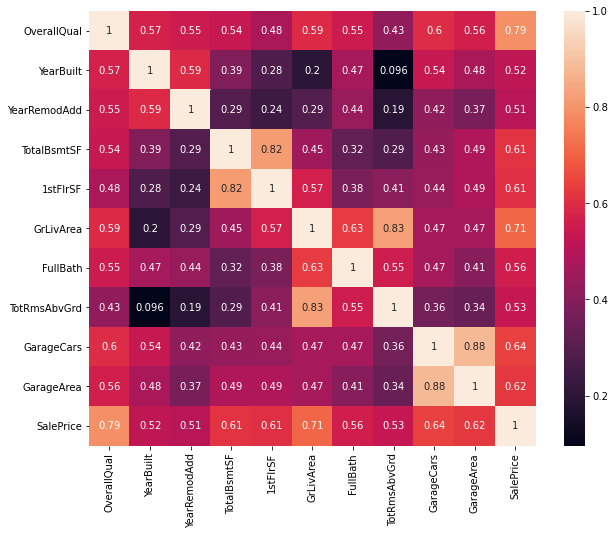

In [7]:
# фичи с корреляцией > 0.5

plt.figure(figsize=(10, 8))

corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
sns.heatmap(train[top_corr_features].corr(), annot=True);

Видим, что больше всего с таргетом коррелирует фича 'общее качество дома и отделки'

## Посмотрим на фичи, которые можно забинить 

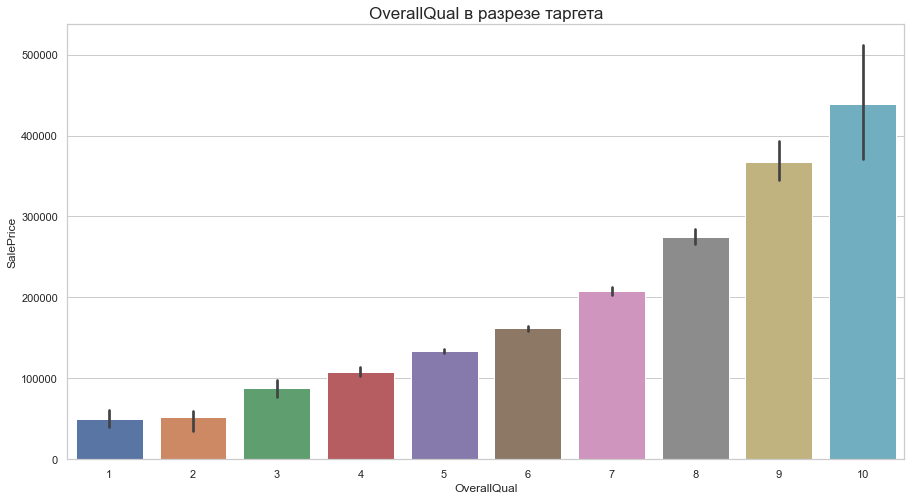

In [8]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.OverallQual, train.SalePrice)
plt.title('OverallQual в разрезе таргета', fontsize=17)

plt.show()

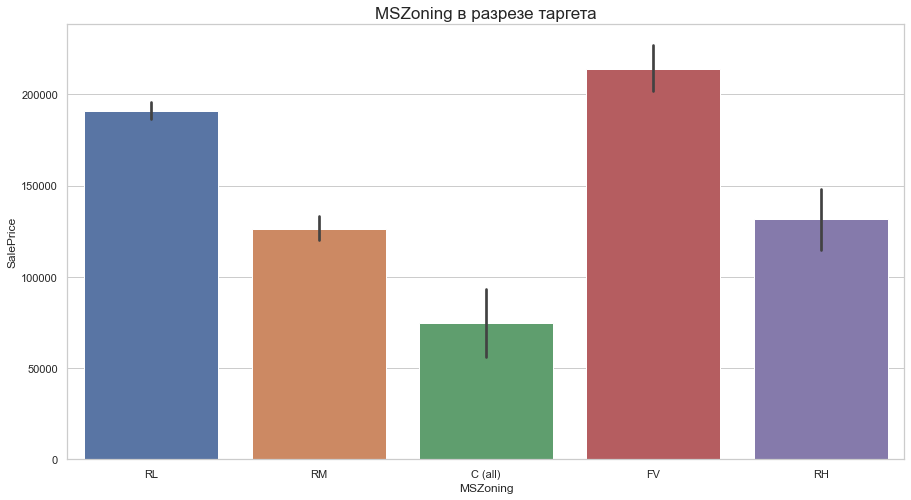

In [9]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.MSZoning, train.SalePrice)
plt.title('MSZoning в разрезе таргета', fontsize=17)

plt.show()

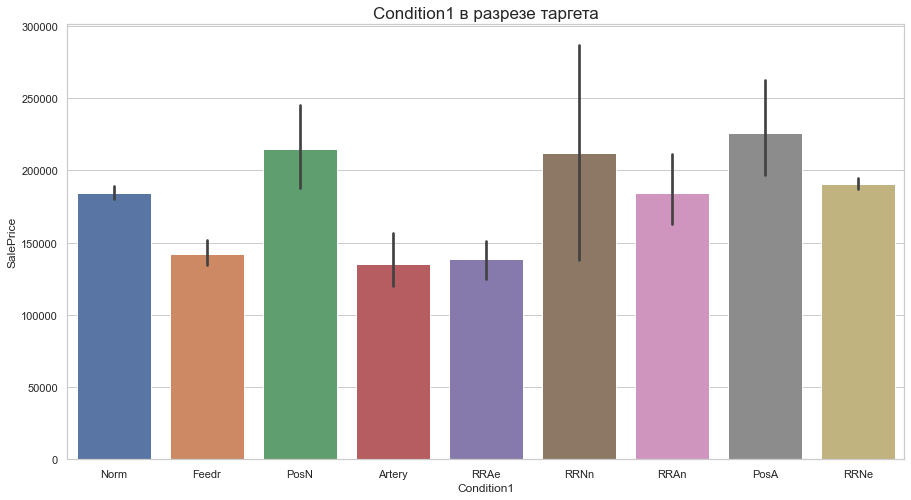

In [10]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.Condition1, train.SalePrice)
plt.title('Condition1 в разрезе таргета', fontsize=17)

plt.show()

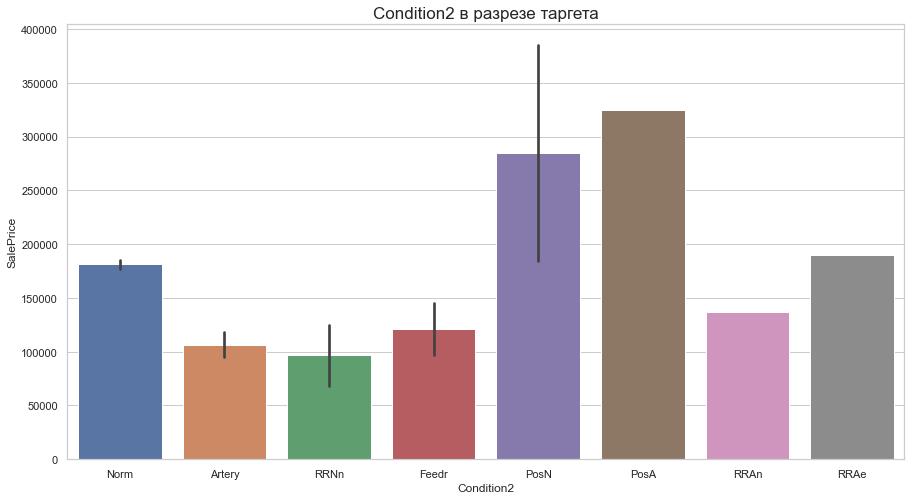

In [11]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.Condition2, train.SalePrice)
plt.title('Condition2 в разрезе таргета', fontsize=17)

plt.show()

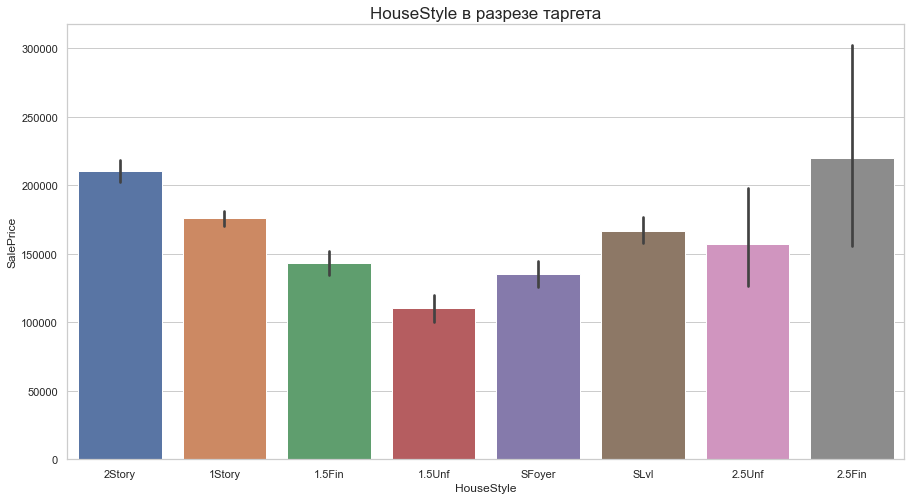

In [12]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.HouseStyle, train.SalePrice)
plt.title('HouseStyle в разрезе таргета', fontsize=17)

plt.show()

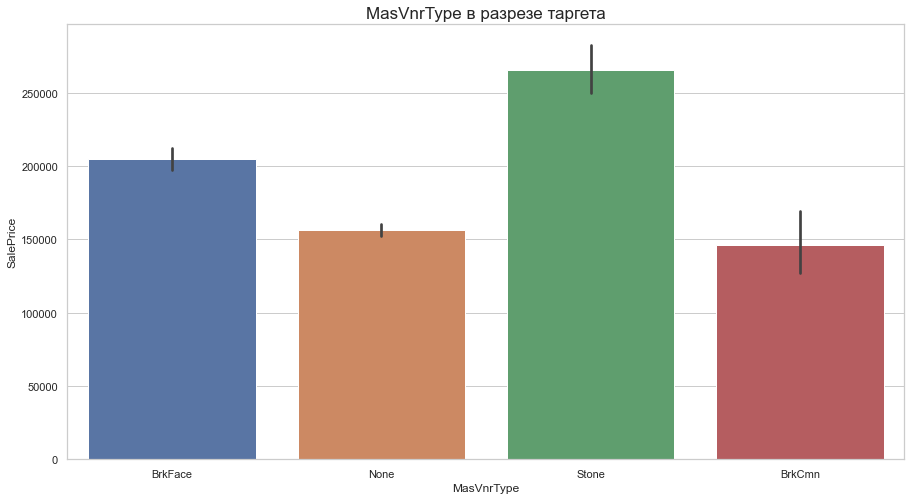

In [13]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.MasVnrType, train.SalePrice)
plt.title('MasVnrType в разрезе таргета', fontsize=17)

plt.show()

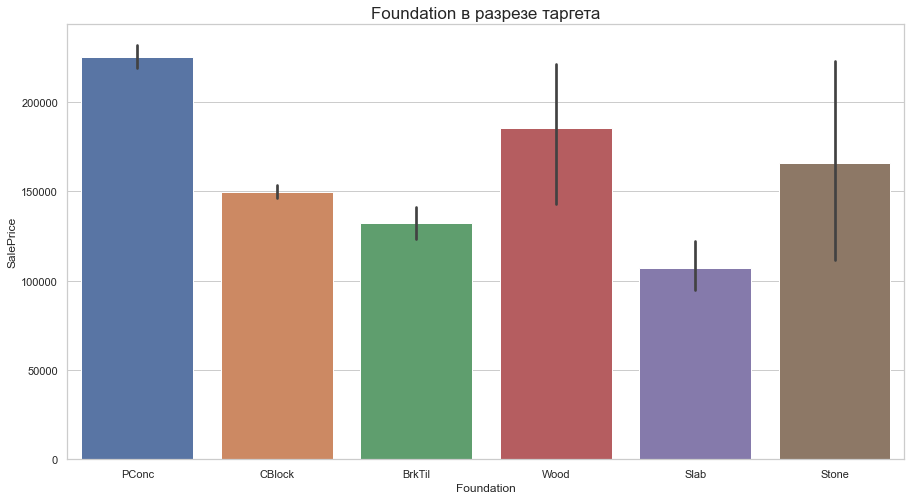

In [14]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.Foundation, train.SalePrice)
plt.title('Foundation в разрезе таргета', fontsize=17)

plt.show()

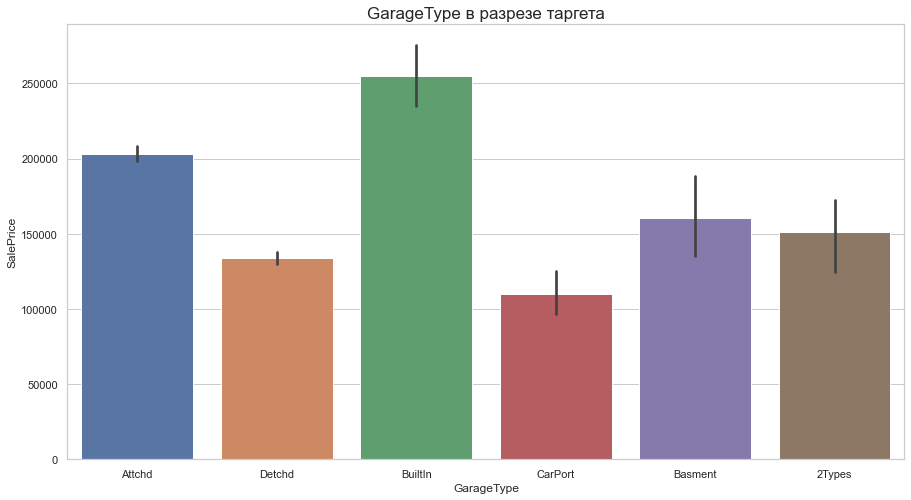

In [15]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.GarageType, train.SalePrice)
plt.title('GarageType в разрезе таргета', fontsize=17)

plt.show()

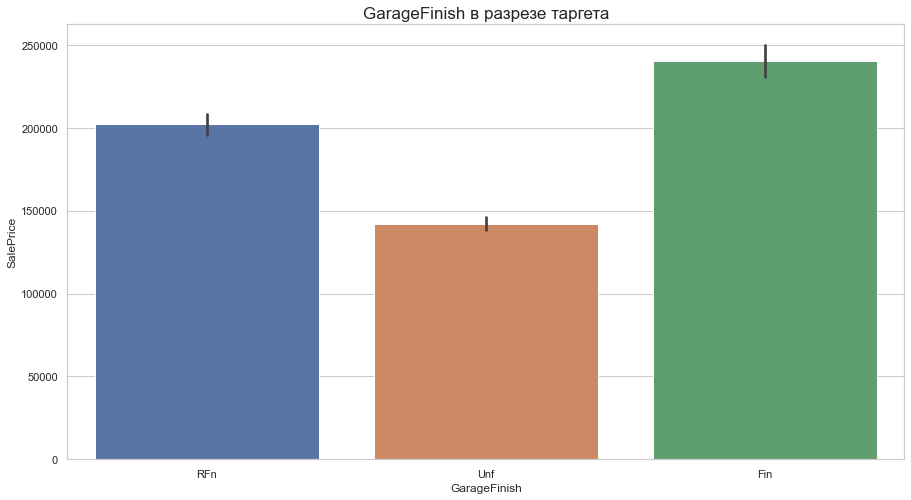

In [16]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.GarageFinish, train.SalePrice)
plt.title('GarageFinish в разрезе таргета', fontsize=17)

plt.show()

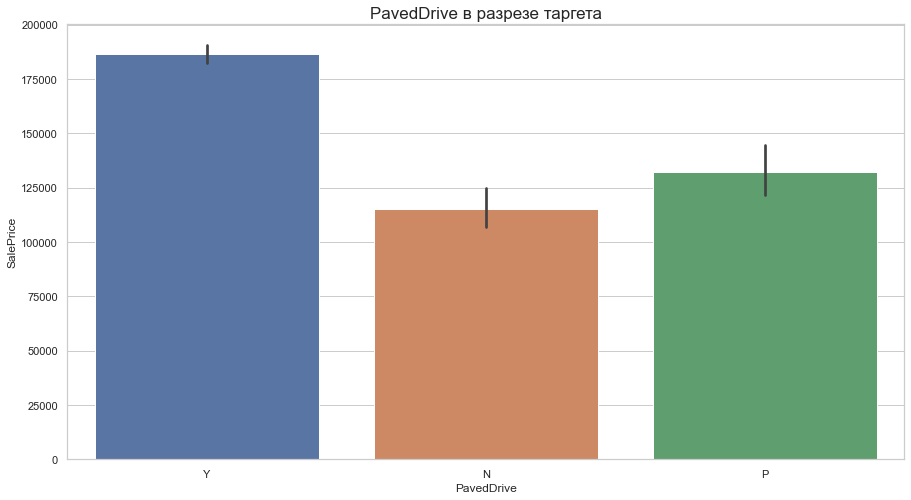

In [17]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.PavedDrive, train.SalePrice)
plt.title('PavedDrive в разрезе таргета', fontsize=17)

plt.show()

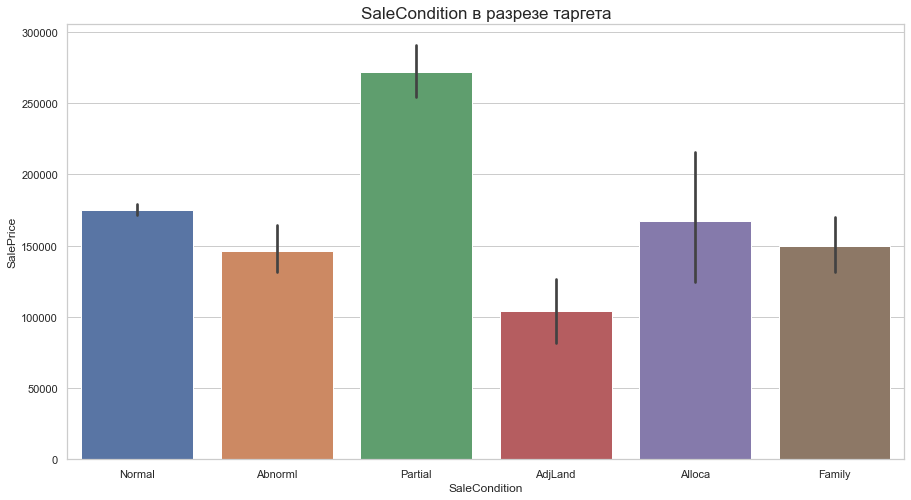

In [18]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(train.SaleCondition, train.SalePrice)
plt.title('SaleCondition в разрезе таргета', fontsize=17)

plt.show()

Довольно явные отличия в цене при разных видах, можно забинить 

## Pairplot

Зависимость линейная

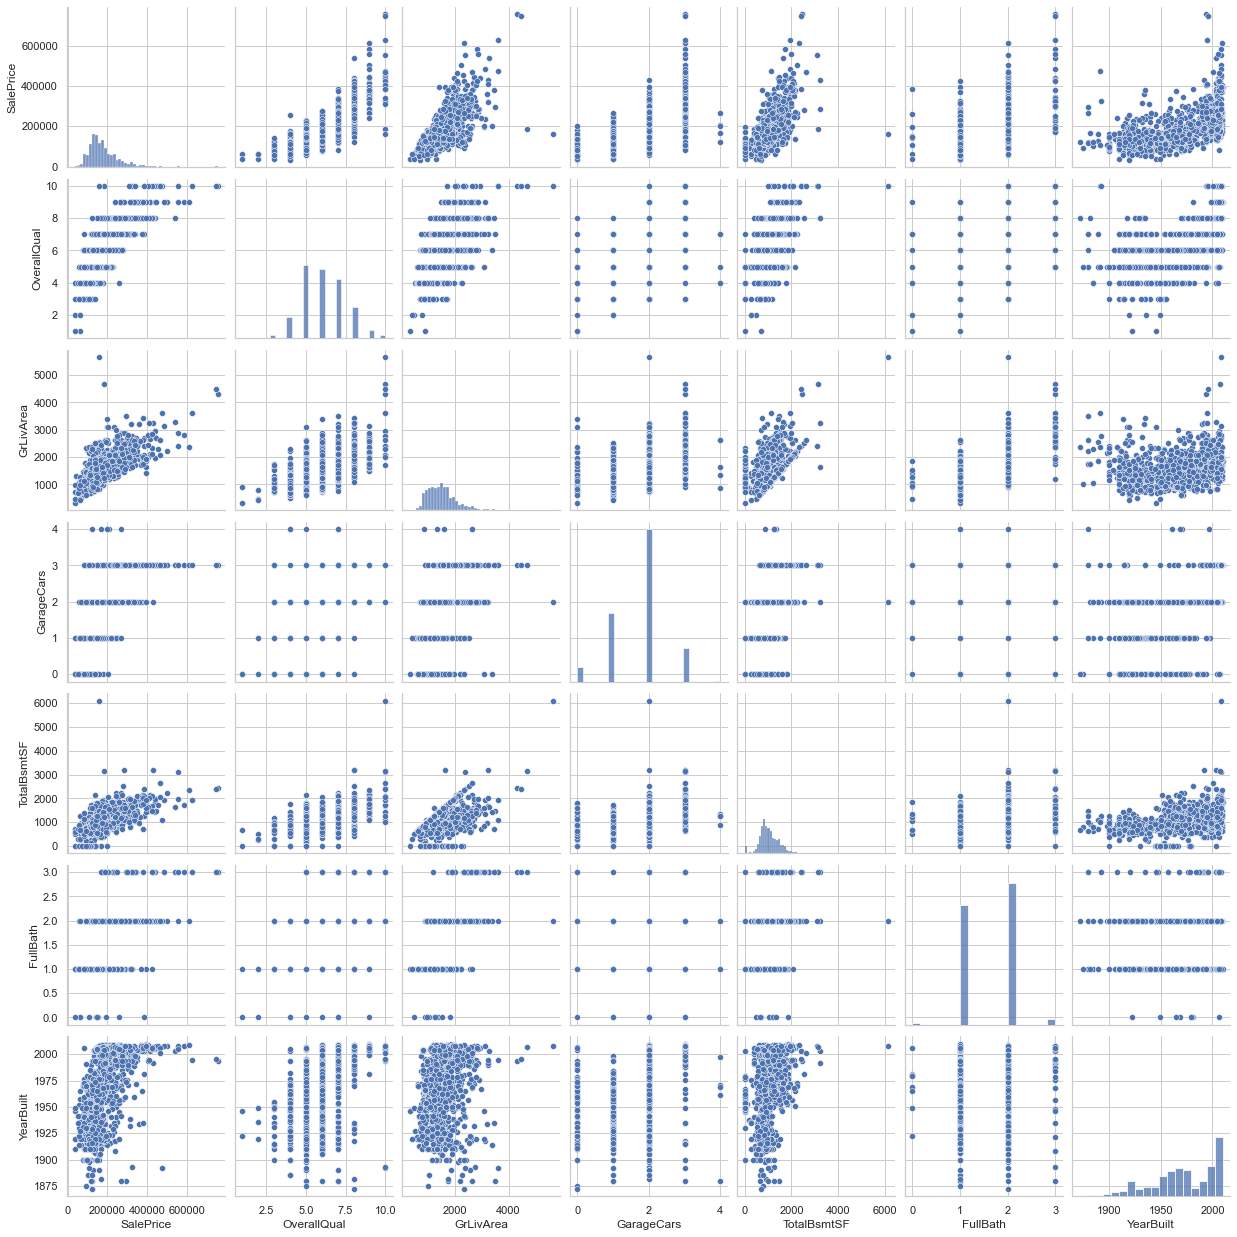

In [19]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

sns.pairplot(train[cols])
plt.show()

Можем посмотреть на распределения наиболее важных фичей

## Посмотрим на распределение таргета

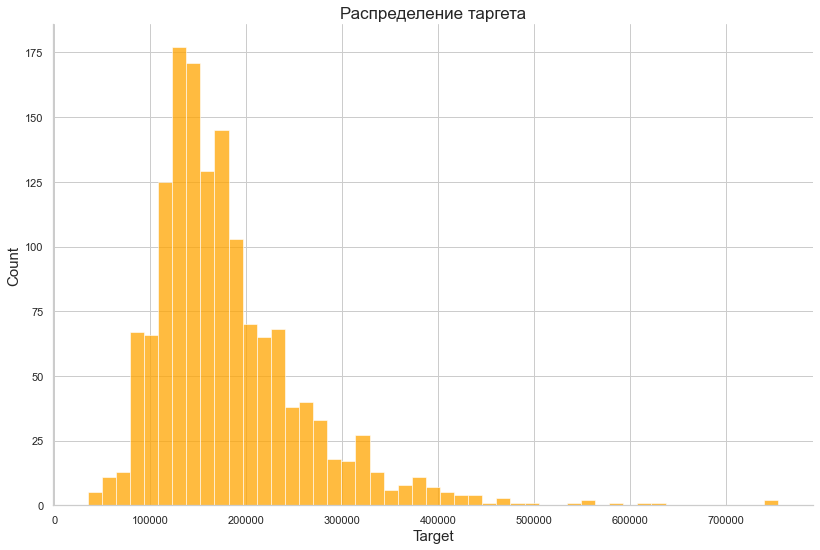

In [20]:
displot = sns.displot(train.SalePrice, color='orange')

displot.fig.set_figheight(8)
displot.fig.set_figwidth(13)

plt.title('Распределение таргета', fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Target', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

Видим тяжелый хвост, а вместе с ней возможность прологарифмировать таргет

# Заполняем пропуски

In [21]:
# Заполняем пропуски в данных

def func_fill(data):
    if isinstance(data, pd.Series):
        try:
            if data.dtype is pd.np.dtype(float):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(int):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(object):
                data.fillna(data.mode()[0], inplace=True)
            else:
                ('Не нашел указанные типы')
        except Exception as ex:
            print(f'Поздравляю, у тебя ошибка - {ex}')
    else:
        print('Series, не DF -_-')

In [22]:
for col in train.columns:
    func_fill(train[col])
    
for col in test.columns:
    func_fill(test[col])

# Preprocessing Train and Test

In [23]:
# Переводим данные в категориальный тип

for col in train.dtypes[train.dtypes == 'O'].index:
    train[col] = train[col].astype('category')
    
for col in test.dtypes[test.dtypes == 'O'].index:
    test[col] = test[col].astype('category')

In [24]:
# Логарифмируем целевую переменную для нормализации распределения

train.SalePrice = np.log(train.SalePrice)

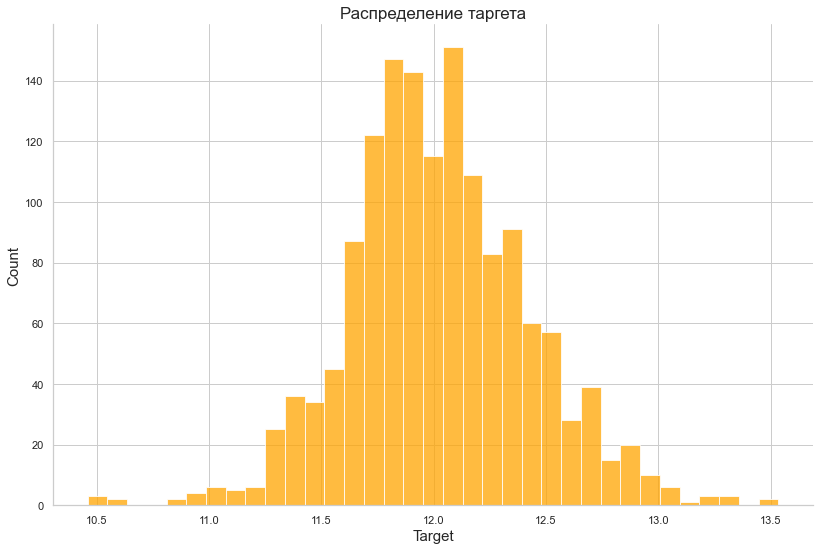

In [25]:
# Строим график распределения таргета

displot = sns.displot(train.SalePrice, color='orange')

displot.fig.set_figheight(8)
displot.fig.set_figwidth(13)

plt.title('Распределение таргета', fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Target', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

# Feature Engineering

На основе информации из EDA переводим признаки в бины, где 0 - наименьшая стоимость, 8 - наибольшая

## MSZoning

In [26]:
train['MSZoning'] = train['MSZoning'].replace(
    {'C (all)': 1, 'RM': 2, 'RH': 3, 'RL': 4, 'FV': 5})

test['MSZoning'] = test['MSZoning'].replace(
    {'C (all)': 1, 'RM': 2, 'RH': 3, 'RL': 4, 'FV': 5})

## Condition1/Condition2

In [27]:
train['Condition1'] = train['Condition1'].replace({'Artery': 1,
                                                   'RRAe': 1,
                                                   'RRNn': 1,
                                                   'Feedr': 1,
                                                   'RRNe': 1,
                                                   'RRAn': 1,
                                                   'Norm': 2,
                                                   'PosA': 3,
                                                   'PosN': 3})

train['Condition2'] = train['Condition2'].replace({'RRNn': 1,
                                                   'Artery': 2,
                                                   'Feedr': 2,
                                                   'RRAn': 2,
                                                   'RRAe': 2,
                                                   'Norm': 2,
                                                   'PosA': 3,
                                                   'PosN': 3})

test['Condition1'] = test['Condition1'].replace({'Artery': 1,
                                                 'RRAe': 1,
                                                 'RRNn': 1,
                                                 'Feedr': 1,
                                                 'RRNe': 1,
                                                 'RRAn': 1,
                                                 'Norm': 2,
                                                 'PosA': 3,
                                                 'PosN': 3})

test['Condition2'] = test['Condition2'].replace({'RRNn': 1,
                                                 'Artery': 2,
                                                 'Feedr': 2,
                                                 'RRAn': 2,
                                                 'RRAe': 2,
                                                 'Norm': 2,
                                                 'PosA': 3,
                                                 'PosN': 3})

## HouseStyle

In [28]:
def HouseStyle_to_int(x: str) -> int:
    
    if x == '1.5Unf':
        q = 0
    elif x == 'SFoyer':
        q = 1
    elif x == '1.5Fin':
        q = 2
    elif x == '2.5Unf':
        q = 3
    elif x == 'SLvl':
        q = 4
    elif x == '1Story':
        q = 5
    elif x == '2Story':
        q = 6  
    elif x == '2.5Fin' :
        q = 7          
    else:
        q = 8
    return q

train['HouseStyle'] = train['HouseStyle'].apply(HouseStyle_to_int)

test['HouseStyle'] = test['HouseStyle'].apply(HouseStyle_to_int)

## MasVnrType

In [29]:
def MasVnrType_to_int(x: str) -> int:
    
    if x == 'Stone':
        q = 3
    elif x == 'BrkFace':
        q = 2
    elif x == 'BrkCmn':
        q = 1        
    else:
        q = 0
    return q

train['MasVnrType'] = train['MasVnrType'].apply(MasVnrType_to_int)

test['MasVnrType'] = test['MasVnrType'].apply(MasVnrType_to_int)

## Foundation

In [30]:
foundation_label = {'Slab': 1, 'BrkTil': 2,
                    'Stone': 2, 'CBlock': 3, 'Wood': 4, 'PConc': 5}

train['Foundation'] = train['Foundation'].replace(foundation_label)

test['Foundation'] = test['Foundation'].replace(foundation_label)

## GarageType

In [31]:
garagetype_label = {'CarPort': 1, 'Basment': 2,
                    'Detchd': 2, 'Attchd': 3, '2Types': 3, 'BuiltIn': 4}

train['GarageType'] = train['GarageType'].replace(garagetype_label)

test['GarageType'] = test['GarageType'].replace(garagetype_label)

## GarageFinish

In [32]:
train['GarageFinish'] = train['GarageFinish'].replace(
    {'Unf': 1, 'RFn': 2, 'Fin': 3})

test['GarageFinish'] = test['GarageFinish'].replace(
    {'Unf': 1, 'RFn': 2, 'Fin': 3})

## PavedDrive

In [33]:
train['PavedDrive'] = train['PavedDrive'].replace(
    {'N': 1, 'P': 2, 'Y': 3})

test['PavedDrive'] = test['PavedDrive'].replace(
    {'N': 1, 'P': 2, 'Y': 3})

## SaleCondition

In [34]:
salecon_label = {'AdjLand': 1, 'Abnorml': 2,
                 'Family': 2, 'Alloca': 2, 'Normal': 3, 'Partial': 4}

train['SaleCondition'] = train['SaleCondition'].replace(salecon_label)

test['SaleCondition'] = test['SaleCondition'].replace(salecon_label)

## Quality Features

In [35]:
quality_label = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

cols = ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC',
        'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'PoolQC']

train[cols] = train[cols].replace(quality_label)

test[cols] = test[cols].replace(quality_label)

# Modeling

In [36]:
# Разбиваем данные на train и test

X = train.drop(['Id', 'SalePrice'], axis=1)
y = train.SalePrice

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RAND)

In [37]:
# DataFrame для записи результатов

metrics = pd.DataFrame(
    index=('MAE', 'MAPE', 'MSE', 'RMSE', 'R2_adjusted', 'RMSLE'))

In [38]:
def r2_adjusted(y_true: list, y_pred: list, X_test: np.array) -> float:
    
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)

# Baseline

## LGBMRegressor

In [39]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [40]:
y_pred = np.exp(lgbm.predict(X_test))

metrics['LGBMRegressor'] = ((mean_absolute_error(y_test, y_pred),
                             mean_absolute_percentage_error(y_test, y_pred),
                             mean_squared_error(y_test, y_pred),
                             np.sqrt(mean_squared_error(y_test, y_pred)),
                             r2_adjusted(y_test, y_pred, X_test),
                             np.sqrt(mean_squared_log_error(y_test, y_pred))))

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE %:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 adjusted:', r2_adjusted(y_test, y_pred, X_test))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

MAE: 175419.75893110965
MAPE %: 14437.937195370321
MSE: 35984560811.905334
RMSE: 189695.96941396868
R2 adjusted: -280419489413.2962
RMSLE: 9.439903965642866


## CatBoostRegressor

In [41]:
cat_cols = train.dtypes[train.dtypes == 'category'].index.to_list()

cat = CatBoostRegressor(cat_features=cat_cols, verbose=False)

eval_set = [(X_test, y_test)]
cat.fit(X_train, y_train, eval_set=eval_set)

In [42]:
y_pred = np.exp(cat.predict(X_test))

metrics['CatBoostRegressor'] = ((mean_absolute_error(y_test, y_pred),
                             mean_absolute_percentage_error(y_test, y_pred),
                             mean_squared_error(y_test, y_pred),
                             np.sqrt(mean_squared_error(y_test, y_pred)),
                             r2_adjusted(y_test, y_pred, X_test),
                             np.sqrt(mean_squared_log_error(y_test, y_pred))))

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE %:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 adjusted:', r2_adjusted(y_test, y_pred, X_test))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

MAE: 175497.6145988465
MAPE %: 14442.08368232926
MSE: 36076730200.98684
RMSE: 189938.75381550455
R2 adjusted: -281137744477.20996
RMSLE: 9.439273981901561


# GridSearchCV

In [45]:
parametrs = {'learning_rate': [0.052, 0.01, 0.1], 
             'max_depth': [6, 3, 13], 
             'iterations': [695, 1000], 
             'bootstrap_type': ['Bayesian', 'MVS'], 
             'l2_leaf_reg': [0.9, 1]}

parametrs = {'learning_rate': [0.052], 
             'max_depth': [6], 
             'iterations': [695], 
             'bootstrap_type': ['Bayesian'], 
             'l2_leaf_reg': [0.9]}

eval_set = [(X_test, y_test)]
grid_cv = GridSearchCV(cat, param_grid=parametrs, verbose=2, cv=3)

In [46]:
grid_cv.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

[CV] END bootstrap_type=Bayesian, iterations=695, l2_leaf_reg=0.9, learning_rate=0.052, max_depth=6; total time=   3.4s
[CV] END bootstrap_type=Bayesian, iterations=695, l2_leaf_reg=0.9, learning_rate=0.052, max_depth=6; total time=   4.0s
[CV] END bootstrap_type=Bayesian, iterations=695, l2_leaf_reg=0.9, learning_rate=0.052, max_depth=6; total time=   4.1s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f9718b381c0>,
             param_grid={'bootstrap_type': ['Bayesian'], 'iterations': [695],
                         'l2_leaf_reg': [0.9], 'learning_rate': [0.052],
                         'max_depth': [6]},
             verbose=2)

In [47]:
y_pred = np.exp(grid_cv.predict(X_test))

metrics['CatBoostRegressor(GridSearch)'] = ((mean_absolute_error(y_test, y_pred),
                             mean_absolute_percentage_error(y_test, y_pred),
                             mean_squared_error(y_test, y_pred),
                             np.sqrt(mean_squared_error(y_test, y_pred)),
                             r2_adjusted(y_test, y_pred, X_test),
                             np.sqrt(mean_squared_log_error(y_test, y_pred))))

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE %:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 adjusted:', r2_adjusted(y_test, y_pred, X_test))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

MAE: 175673.15890595265
MAPE %: 14458.397849507553
MSE: 36072921185.73983
RMSE: 189928.72659431965
R2 adjusted: -281108061688.6296
RMSLE: 9.441754216132704


In [48]:
# Выводим метрики

metrics.T.style.highlight_max(color='orange', axis=0)

,MAE,MAPE,MSE,RMSE,R2_adjusted,RMSLE
LGBMRegressor,175419.758931,14437.937195,35984560811.905334,189695.969414,-280419489413.296204,9.439904
CatBoostRegressor,175497.614599,14442.083682,36076730200.986839,189938.753816,-281137744477.209961,9.439274
CatBoostRegressor(GridSearch),175673.158906,14458.397850,36072921185.739830,189928.726594,-281108061688.629578,9.441754


# Submission

In [49]:
ids = test['Id']
predict = np.exp(cat.predict(test.drop(['Id'], axis=1)))

output = pd.DataFrame({'Id': ids, 'SalePrice': predict})

In [50]:
output.to_csv('submission.csv', index=False)

In [51]:
output

,Id,SalePrice
0,1461,122005.504687
1,1462,159141.471129
2,1463,187815.724994
3,1464,197949.396316
4,1465,192043.477282
...,...,...
1454,2915,81631.348500
1455,2916,82384.964167
1456,2917,157453.296979
1457,2918,117389.704508
